# Retrieve data from Google Sholar

Yedidya Harris, June 2023

## Get HTML source code

In [ ]:
# installing packages for, using mozilla web-driver
!pip install selenium
!apt-get update
!apt install firefox -y
!wget https://github.com/mozilla/geckodriver/releases/download/v0.30.0/geckodriver-v0.30.0-linux64.tar.gz
!tar -xvzf geckodriver-v0.30.0-linux64.tar.gz

In [16]:
# import libs
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
import time
from tqdm import tqdm
from bs4 import BeautifulSoup
import pandas as pd

# function to retrieve page source of a given url
def get_page_source(url):
    # Configure the WebDriver options
    options = Options()
    options.add_argument('--headless')  # Optional: Run Firefox in headless mode to avoid opening a browser window

    # Path to the geckodriver executable
    firefox_driver_path = 'path/to/geckodriver'

    # Create a Service object using the geckodriver executable
    service = Service(firefox_driver_path)

    # Create the Firefox webdriver passing the Service and options objects
    driver = webdriver.Firefox(service=service, options=options)

    # Open the URL in the browser
    driver.get(url)

    # Get the source code of the page
    page_source = driver.page_source

    # Close the browser
    driver.quit()

    return page_source

## Retrieve User IDs from Google Scholar Profiles search results 

link: https://scholar.google.com/citations?hl=en&view_op=search_authors&mauthors

In [17]:
# function to extract the user ids from the specific page
def extract_user_ids_from_html(html_source_code):
    # with open(html_file, 'r') as file:
    #     html_content = file.read()

    soup = BeautifulSoup(html_source_code, 'html.parser')
    user_ids = []
    names = []

    # Find all the anchor tags containing 'user=' in href attribute
    anchor_tags = soup.find_all('a', href=lambda href: href and 'user=' in href)
    
    for anchor_tag in anchor_tags:
        # Extract the user ID from the href attribute
        href = anchor_tag['href']
        user_id = href.split('user=')[1]
        if len(user_id) >= 2:  # Filter out user IDs with less than 2 characters
            user_ids.append(user_id)
            names.append(anchor_tag.text)

    # Create a new dataframe to store the user IDs
    df = pd.DataFrame({'Name': names, 'User ID': user_ids})

    return df

In [ ]:
# Each page has 10 results (10 researches)
# in order to view the next 10, the user needs to click on screen the right arrow button (next)
# function to automate clicking next in search results, and save user ids

# Configure the WebDriver options
options = Options()
options.add_argument('--headless')  # Optional: Run Firefox in headless mode to avoid opening a browser window

# Path to the geckodriver executable
firefox_driver_path = 'path/to/geckodriver'

# Create a Service object using the geckodriver executable
service = Service(firefox_driver_path)

# Create the Firefox webdriver passing the Service and options objects
driver = webdriver.Firefox(service=service, options=options)

# Open the initial URL in the browser
url = 'https://scholar.google.com/citations?hl=en&view_op=search_authors&mauthors=Hebrew+University+of+Jerusalem&btnG=' # the url for HUJI search results (first 10 results)
driver.get(url)

# function to click next page button and get page source
def next_page():
  # Find and click the "Next" button
  next_button = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//button[@aria-label="Next"]')))
  next_button.click()
  
  new_page_element = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, 'gsc_authors_bottom_pag'))) # Wait for the new page to load
  new_page_source = driver.page_source
  return new_page_source

# iterate for n clicks. Remember each click, is like 10 results. 
for i in tqdm(range(500)):
  page_source = next_page()
  extract_user_ids_from_html(page_source)
  df_user_ids = extract_user_ids_from_html(page_source)

  # Check if i is a multiple of 100 - temp saving
  if i % 100 == 0:
      # Save total_df as a CSV file
      total_df.to_csv(f'total_df_{i}.csv', index=False)

  total_df = pd.concat([total_df, df_user_ids], ignore_index=True)  # Concatenate df_user_ids to total_df
  unique_ppl = len(total_df['User ID'].unique())


# remove empty names, and save the final csv
total_df = total_df[total_df['Name'].str.strip().ne('')]
total_df = total_df.reset_index(drop=True)
total_df.to_csv(f'total_df_final.csv', index=False)
files.download('total_df_final.csv')

total_df

# Close the browser
driver.quit()


In [ ]:
# check how many unique user ids we retrieved
len(total_df['User ID'].unique())

1522

## Retrieve h-index and i10-index from user profiles

In [18]:
from bs4 import BeautifulSoup
import pandas as pd

# extract the indices (and Name) from the user profile HTML source code
def extract_information(html_src_code):

    soup = BeautifulSoup(html_src_code, 'html.parser')
    name = soup.find('div', id='gsc_prf_in').text.strip()
    h_index = int(soup.find('td', class_='gsc_rsb_sc1', text='h-index').find_next_sibling('td').text)
    i10_index = int(soup.find('td', class_='gsc_rsb_sc1', text='i10-index').find_next_sibling('td').text)
    
    df = pd.DataFrame({'Name': [name],
                       'h-index': [h_index],
                       'i10-index': [i10_index]})
    
    return df

In [19]:
# read in our User IDs df from the prev step
total_df = pd.read_csv('/content/user_ids_huji_scholar.csv')
total_df

,Name,User ID
0,Eli Keshet,4YRS90cAAAAJ
1,Aharon Oren,KsLkloMAAAAJ
2,Boas Shamir,VcPuvXEAAAAJ
3,Moran Yassour,IjYkZSAAAAAJ
4,Noam Nisan,zXQZPnMAAAAJ
...,...,...
11553,Gili Lior,eAezvBwAAAAJ
11554,Omri Haim,Pym3jj0AAAAJ
11555,Gili Lior,eAezvBwAAAAJ
11556,Omri Haim,Pym3jj0AAAAJ


In [ ]:
# Retrieve all h-index and i10-index from user profiles in the above df
total_profiles = pd.DataFrame()  # Initialize an empty DataFrame

i = 0

ids_to_scrape = total_df['User ID'].unique()
for user_id in tqdm(ids_to_scrape):
  profile_url = f'https://scholar.google.com/citations?hl=en&user={user_id}'
  page_source = get_page_source(profile_url)
  profile_df = extract_information(page_source)

  total_profiles = pd.concat([total_profiles, profile_df], ignore_index=True)  
  # Check if i is a multiple of 100
  if i % 100 == 0:
      # Save total_df as a CSV file
      total_profiles.to_csv(f'total_profiles_{i}.csv', index=False)
  i = i +1


In [39]:
from google.colab import files

total_profiles.to_csv(f'total_profiles_final2.csv', index=False)
files.download('total_profiles_final2.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [38]:
len(total_profiles['Name'].unique())

1492

In [45]:
total_profiles.info

<bound method DataFrame.info of                Name  h-index  i10-index
0        Eli Keshet       66        120
1       Aharon Oren       94        393
2       Boas Shamir       63         95
3     Moran Yassour       26         32
4        Noam Nisan       76        154
...             ...      ...        ...
1496    Idit Ben Or        1          0
1497  Zhidong Zhang        1          0
1498    Roie Ezraty        1          0
1499  Caoimhe Moran        1          0
1500   Gili Kurtser        1          0

[1501 rows x 3 columns]>

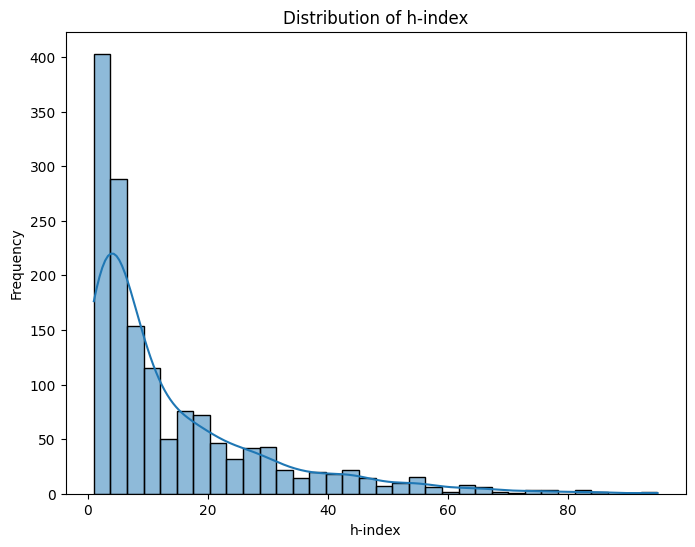

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = total_profiles.copy()
# Plotting graphs
# 1. Histogram of h-index
plt.figure(figsize=(8, 6))
sns.histplot(df['h-index'], kde=True)
plt.xlabel('h-index')
plt.ylabel('Frequency')
plt.title('Distribution of h-index')
plt.show()


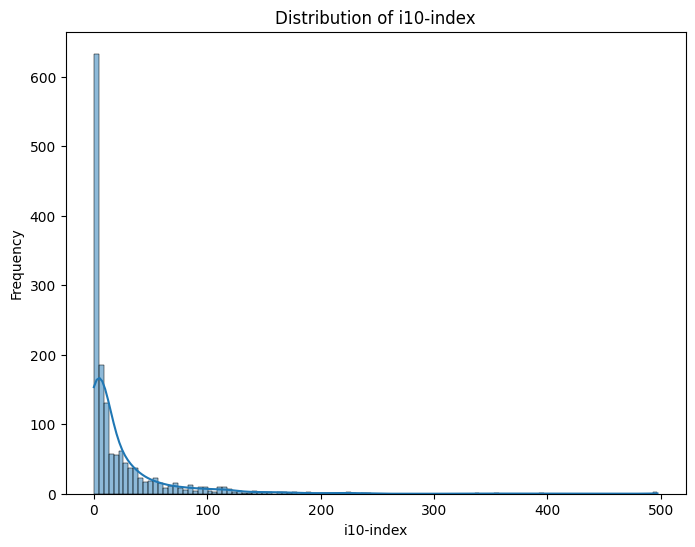

In [49]:
# 2. Histogram of i10-index
plt.figure(figsize=(8, 6))
sns.histplot(df['i10-index'], kde=True)
plt.xlabel('i10-index')
plt.ylabel('Frequency')
plt.title('Distribution of i10-index')
plt.show()

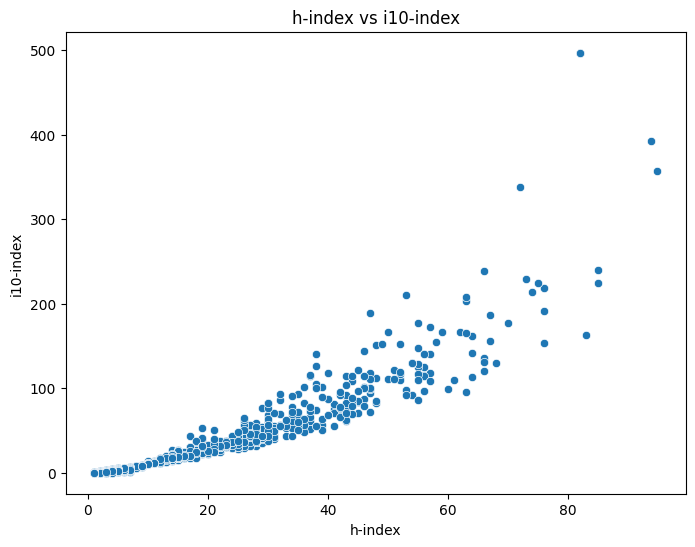

In [50]:
# 3. Scatter plot of h-index vs i10-index
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='h-index', y='i10-index')
plt.xlabel('h-index')
plt.ylabel('i10-index')
plt.title('h-index vs i10-index')
plt.show()

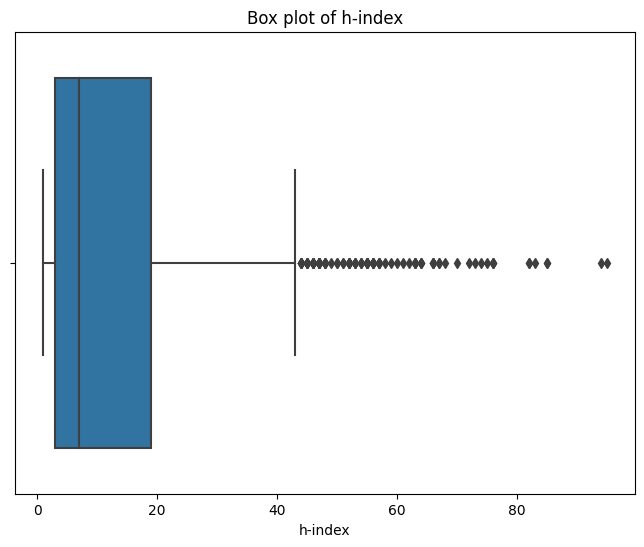

In [51]:
# 4. Box plot of h-index by quartiles
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='h-index')
plt.xlabel('h-index')
plt.title('Box plot of h-index')
plt.show()

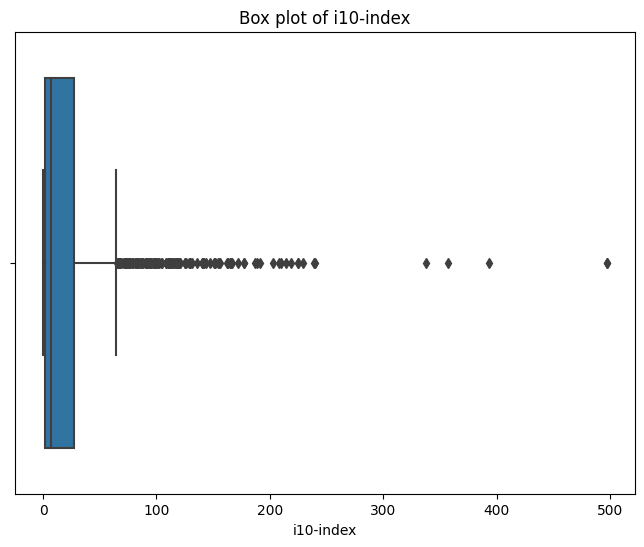

In [52]:
# 5. Box plot of i10-index by quartiles
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='i10-index')
plt.xlabel('i10-index')
plt.title('Box plot of i10-index')
plt.show()